In [1]:
import glob
from pylab import *

def read_ps_voltage(file):
    read_data = np.genfromtxt(file, skip_header=1, delimiter=',')
    return read_data[:, 1]

# Messungen

Wir haben angefangen 20 verschiedene Entfernungen zu messen und diese mit der Picoscope Software in 20 einzelne CSV Dateien gespeichert.

In [2]:
files = glob.glob("cleaned/*cm*.csv")

# [reference in mm, all voltage values]
data = {
    100: read_ps_voltage(files[0]),
    130: read_ps_voltage(files[1]),
    160: read_ps_voltage(files[2]),
    180: read_ps_voltage(files[3]),
    220: read_ps_voltage(files[4]),
    245: read_ps_voltage(files[5]),
    250: read_ps_voltage(files[6]),
    280: read_ps_voltage(files[7]),
    300: read_ps_voltage(files[8]),
    340: read_ps_voltage(files[9]),
    380: read_ps_voltage(files[10]),
    410: read_ps_voltage(files[11]),
    460: read_ps_voltage(files[12]),
    490: read_ps_voltage(files[13]),
    520: read_ps_voltage(files[14]),
    580: read_ps_voltage(files[15]),
    620: read_ps_voltage(files[16]),
    650: read_ps_voltage(files[17]),
    690: read_ps_voltage(files[18]),
    710: read_ps_voltage(files[19]),
}

data_mean = {k: np.mean(v) for k,v in data.items()}

measurements = np.array(list(data_mean.items()))

Wir können jetzt diese daten plotten.

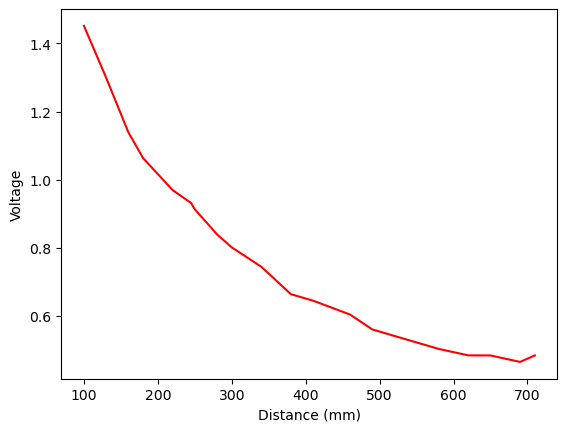

In [3]:
figure()
plot(measurements[:, 0], measurements[:, 1], 'r')
xlabel("Distance (mm)")
ylabel("Voltage")
show()